---
title: "Stochastic Volatility model in C++ (using pybind11)"
---

In [1]:
#!pip install "git+https://github.com/SaremS/side-projects.git#egg=stochastic_volatility_model&subdirectory=stoch-vola/model"


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from findiff import FinDiff
from stochastic_volatility_model import StochasticVolatilityModel

[*********************100%***********************]  1 of 1 completed


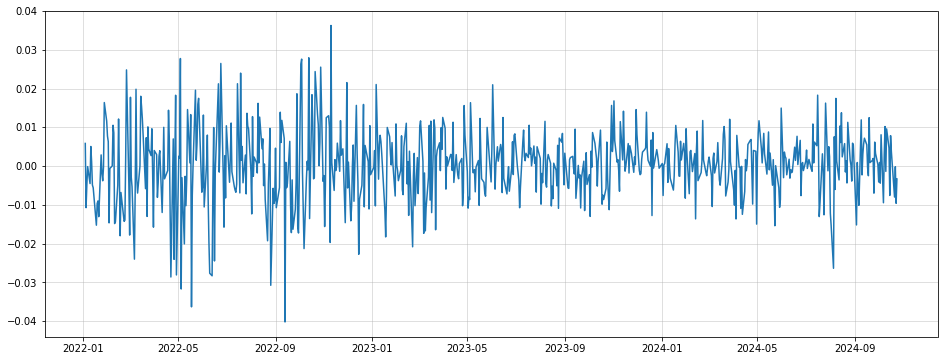

In [3]:
tickers = ['^DJI']

# Download the data from yfinance
df = yf.download(tickers, start="2022-01-01", end="2024-10-25")

dfp = df["Adj Close"]
dfr = np.log(dfp).diff().dropna()

plt.figure(figsize = (16,6))
plt.plot(dfr)
plt.grid(alpha=0.5)

In [4]:
from scipy.stats import norm

class RandomVolatility:

    def __init__(self, alpha, beta, sigma):
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma

    def particle_filter(self, y, M=100, seed=321):
        np.random.seed(seed)
        T = len(y)
        
        alpha = self.alpha
        beta = np.tanh(self.beta)
        q_sigma = np.exp(self.sigma)

        particles = np.random.normal(size=(T+1,M)) * q_sigma

        for t in range(1,T+1):
            q_mus = alpha + beta * (particles[t-1,:] - alpha)
            particles_t = np.random.normal(size=(M,))*q_sigma + q_mus
            particles[t,:] = particles_t

            obs_dists = norm(loc=0.0, scale=np.exp(particles_t/2))

            w_t = obs_dists.pdf(y[t-1])

            w_t = w_t/np.sum(w_t)

            a_t = np.random.choice(np.arange(M),M,p=w_t,replace=True)
            particles = particles[:,a_t]

        return particles[1:,:]

    def particle_filter_ll(self, y, M=100, seed=123):
        particles = self.particle_filter(y, M, seed)

        obs_dists = norm(loc=0.0, scale=np.exp(particles/2))

        like = obs_dists.pdf(y.reshape(-1,1)).mean(1)
        like[like==0] = np.min(like)
        
        return np.log(like).mean()
        

In [5]:
%%time
##Python
RandomVolatility(np.log(np.std(dfr.values))*2, 5.0, 0.0).particle_filter_ll(dfr.values,M=100)

CPU times: user 593 ms, sys: 8.88 ms, total: 602 ms
Wall time: 604 ms


3.428327859504868

In [6]:
%%time
##C++
StochasticVolatilityModel(np.log(np.std(dfr.values))*2, 5.0, 0.0).logLikelihood(dfr.values,100,321)

CPU times: user 79.3 ms, sys: 2.11 ms, total: 81.4 ms
Wall time: 82 ms


0.17236234874419082

In [7]:
from scipy.optimize import minimize
dfrv = dfr.values

xn = np.array([np.log(np.std(dfr.values))*2, 5.0, 0.0])
result = minimize(lambda x: -StochasticVolatilityModel(*x).logLikelihood(dfrv,100,321), xn)

In [8]:
parts = StochasticVolatilityModel(*result.x).particleFilter(dfrv,1000,123)
ps = parts.getParticles()

In [9]:
means = np.mean(np.exp(np.array(ps)/2),1)
lower = np.quantile(np.exp(np.array(ps)/2),0.05,1)
upper = np.quantile(np.exp(np.array(ps)/2),0.95,1)

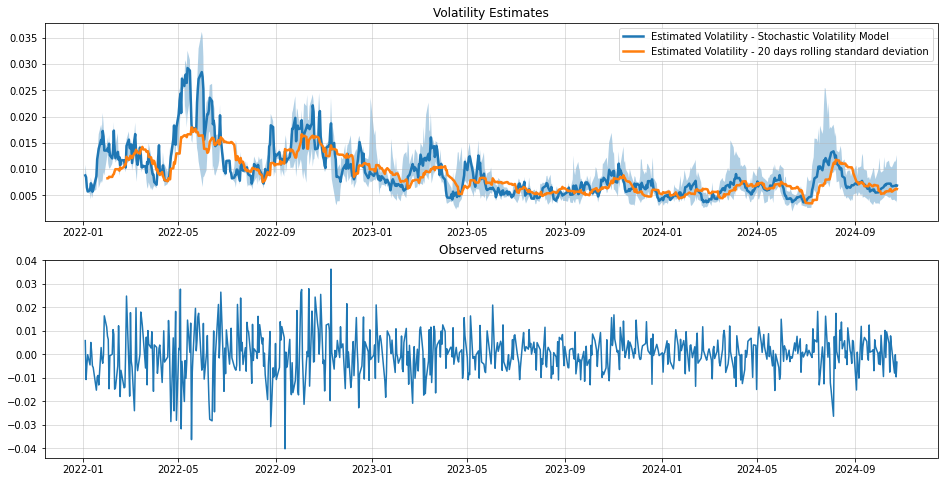

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

axs[0].set_title("Volatility Estimates")
axs[0].plot(dfr.index, means, lw=2.5, label="Estimated Volatility - Stochastic Volatility Model")
axs[0].grid(alpha=0.5)
axs[0].fill_between(dfr.index, upper, lower,alpha=0.35)
axs[0].plot(dfr.rolling(20).std(), lw=2.5, label="Estimated Volatility - 20 days rolling standard deviation")
axs[0].legend()


axs[1].set_title("Observed returns")
axs[1].plot(dfr, label="^DJI")
axs[1].grid(alpha=0.5)